In [10]:
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt 


In [11]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({"font.size" : 14})

In [12]:
def gamblers_ruin():
    gambling_money = 50
    gambling_goal = 100
    gambling_simulations = []
    
    while gambling_money in range(1,gambling_goal):
        bet_size = 1
        w_or_l = random.randrange(-1,2,2)
        gambling_money+= bet_size * w_or_l
        gambling_simulations.append(gambling_money)
    return gambling_simulations

Text(0.5, 1.0, 'Gambling Simulation')

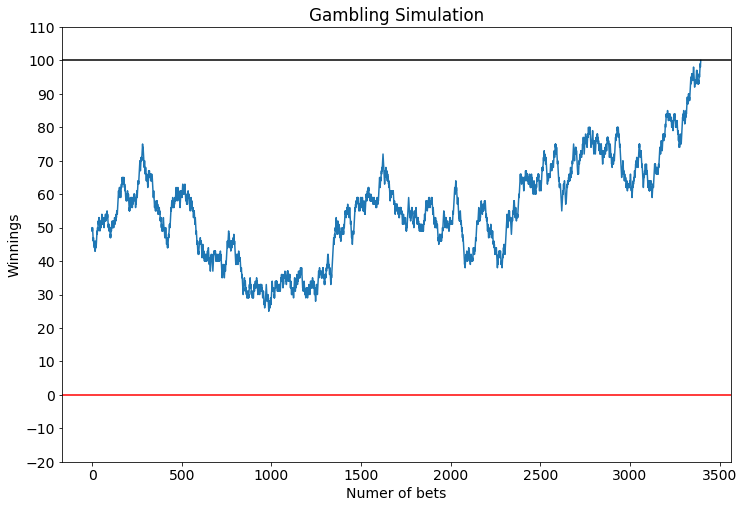

In [13]:
plt.plot(gamblers_ruin())
plt.yticks(np.arange(-20,120,10))
plt.axhline(y=0,color="red",linestyle ="-")
plt.axhline(y=100,color="black",linestyle ="-")
plt.xlabel("Numer of bets")
plt.ylabel("Winnings")
plt.title("Gambling Simulation")

In [14]:
def prob_of_ruin(gambling_goal, initial_gambling_money):
    return (gambling_goal - initial_gambling_money)/gambling_goal



In [15]:
prob_of_ruin(100,50)

0.5

In [16]:
sim_list = []
while len(sim_list) < 500:
    sim_list.append(gamblers_ruin()[-1])
np.mean(sim_list)

45.4

**Markov Chain Simulations**

In [17]:
example = {
    "NYC":    [.25,0,.75,1],
    "Paris" : [.25,.25,0,0],
    "Cairo" : [.25,.25,.25,0],
    "Seoul" : [.25,.50,0,0]
}

markov_chain = pd.DataFrame(data=example,index = ["NYC","Paris","Cairo","Seoul"])
markov_chain

,NYC,Paris,Cairo,Seoul
NYC,0.25,0.25,0.25,0.25
Paris,0.00,0.25,0.25,0.50
Cairo,0.75,0.00,0.25,0.00
Seoul,1.00,0.00,0.00,0.00


In [18]:

# from markovchain import MarkovChain
# markov_chain_diagram = MarkovChain(example,["NYC","Paris","Cairo","Seoul"])
# markov_chain_diagram.draw()



In [19]:
travel_sim = []
travel_sim.append(markov_chain.iloc[0].index[0])
city = np.random.choice(markov_chain.iloc[0].index,p=markov_chain.iloc[0])
travel_sim.append(city)

while len(travel_sim) < 25:
    city = np.random.choice(markov_chain.iloc[markov_chain.index.get_loc(city)].index,p=markov_chain.iloc[markov_chain.index.get_loc(city)])
    travel_sim.append(city)

travel_sim

['NYC',
 'Cairo',
 'Cairo',
 'NYC',
 'NYC',
 'NYC',
 'Seoul',
 'NYC',
 'Cairo',
 'NYC',
 'Cairo',
 'NYC',
 'NYC',
 'Paris',
 'Seoul',
 'NYC',
 'Paris',
 'Seoul',
 'NYC',
 'Cairo',
 'NYC',
 'NYC',
 'Paris',
 'Seoul',
 'NYC']

In [20]:
markov_chain.to_numpy()

array([[0.25, 0.25, 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.75, 0.  , 0.25, 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

**n Step Transition Matrix**\n
,in this case it n = 2

In [22]:
np.dot(markov_chain.to_numpy(),markov_chain.to_numpy())

array([[0.5   , 0.125 , 0.1875, 0.1875],
       [0.6875, 0.0625, 0.125 , 0.125 ],
       [0.375 , 0.1875, 0.25  , 0.1875],
       [0.25  , 0.25  , 0.25  , 0.25  ]])

In [ ]:
def matrix_power(matrix,power):
    if power ==0:
        return np.identity(len(matrix))
    elif power ==1:
        return matrix
    else:
        return np.dot(matrix,matrix_power(matrix,power-1))

